In [1]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

## Plateau Climate

This climate can be found on different plateaus in the USA, however this well is located on the Columbian Plateau that covers part of the states Washington, Idaho and Oregon. The climate can be described as slightly continental with cold winters, where the temperatures range from 0 to 5 degrees Celsius. The summers are warm with temperatures between 15 and 20 degrees Celsius, but the night can be cool. Rain mostly falls in December, where the summer months of July, August and September are dry. 

This well is situated near Spokane on a height of 627.6 meters. The well is part of the Columbia Plateau basin-fill aquifer and it is classified as an unconfined aquifer. The water in the well is between 25 and 33 meters below the ground surface. The lithology of the well is unknown.

The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [2]:
map = folium.Map(location=[47.62, -117.53], zoom_start=6)
folium.Marker([47.62, -117.53], popup='Weather Station').add_to(map)
folium.Marker([47.67, -117.13], popup='Well').add_to(map);

In [3]:
map

### Importing Data

#### Spokane, Well 47401117072901
#### Groundwater series

In [4]:
height = 627.57 # meters above mean sea level

head_import = pd.read_csv('GW_Data/Spokane_474011117072901.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

head = head.loc[~head.index.duplicated(keep='first')]

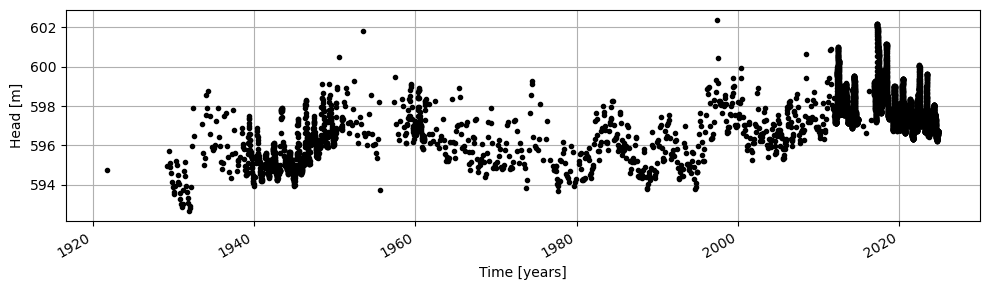

In [5]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

#### Precipitation

In [6]:
prec = pd.read_csv('Prec_temp/Spokane_3976462.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'PRCP'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

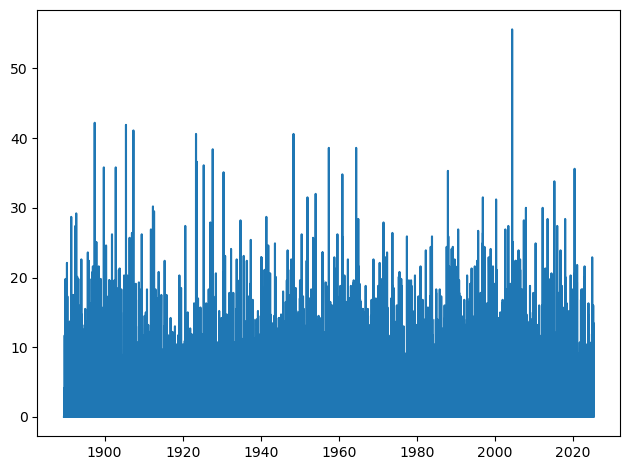

In [7]:
plt.plot(PRCP)

#### Evaporation

In [8]:
evap = pd.read_csv('Evap/Tallahasse.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'Hargreaves'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

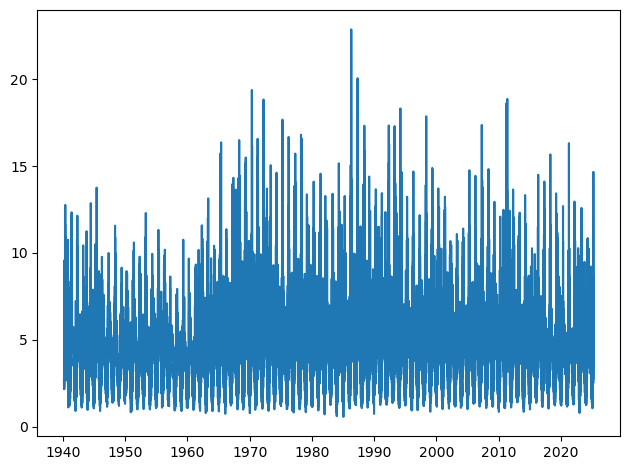

In [9]:
plt.plot(EPOT)

### Pastas Application

Resampling the stresses to create a regular timestep

In [10]:
EPOT = EPOT.resample("24h", closed="right", label="right").mean()
PRCP = PRCP.resample("24h", closed="right", label="right").mean()

#### Basic Pastas Model

In [11]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve(tmin='1940')

INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'Hargreaves' was extended in the past to 1930-01-03 00:00:00 with the mean value (4.3) of the time series.


Fit report Value                 Fit Statistics
nfev    33                     EVP        43.87
nobs    5151                   R2          0.44
noise   False                  RMSE        0.99
tmin    1940-01-01 00:00:00    AICc      -56.58
tmax    2024-10-31 00:00:00    BIC       -23.85
freq    D                      Obj      2542.42
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
                 optimal     initial  vary
rch_A       9.362437e+00    0.268052  True
rch_n       6.812429e-01    1.000000  True
rch_a       3.889226e+03   10.000000  True
rch_f      -6.994296e-26   -1.000000  True
constant_d  5.870063e+02  597.431278  True

Warnings! (1)
Parameter 'rch_f' on upper bound: 0.00e+00


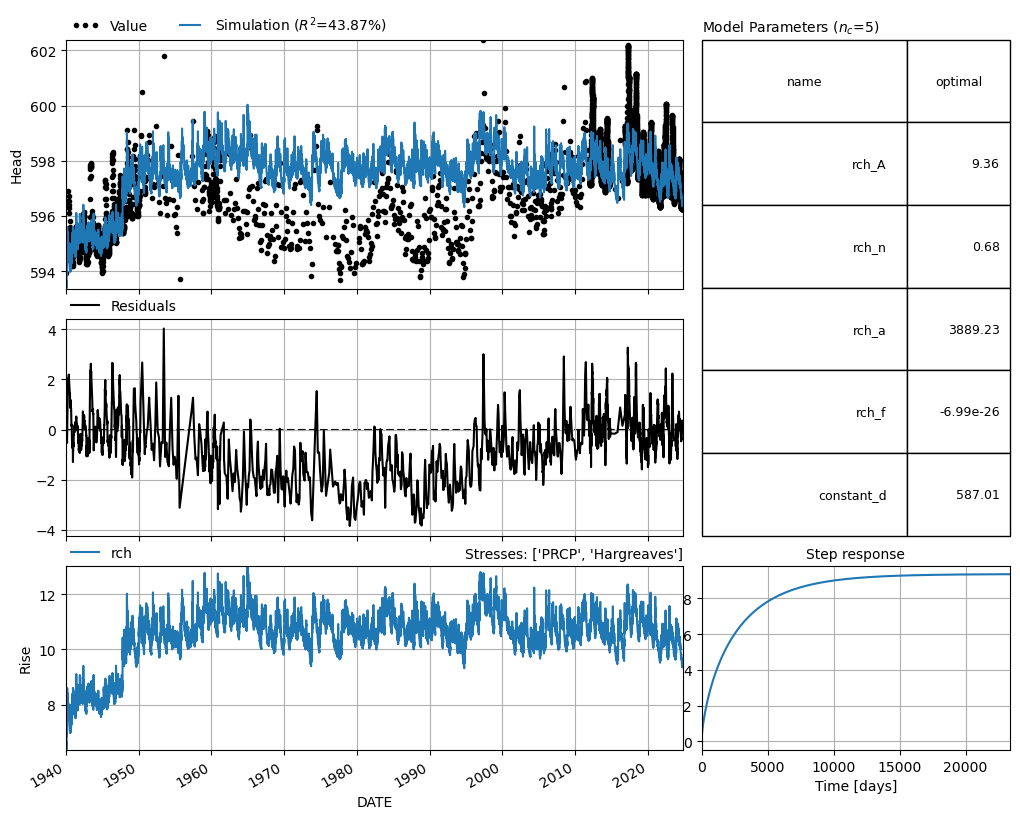

In [12]:
ml.plots.results();

#### Resample Monthly

In [13]:
head_resampled = head.resample('M').last()

In [14]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve(tmin='1940')

INFO: Time Series 'Value': 300 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'Hargreaves' was extended in the past to 1930-01-03 00:00:00 with the mean value (4.3) of the time series.


Fit report Value                Fit Statistics
nfev    38                     EVP       30.57
nobs    847                    R2         0.31
noise   False                  RMSE       1.19
tmin    1940-01-01 00:00:00    AICc     297.69
tmax    2024-10-31 00:00:00    BIC      321.32
freq    D                      Obj      594.74
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (5 optimized)
                optimal     initial  vary
rch_A          9.047964    0.268052  True
rch_n          0.906937    1.000000  True
rch_a       1350.284016   10.000000  True
rch_f         -0.011777   -1.000000  True
constant_d   586.668621  596.452808  True


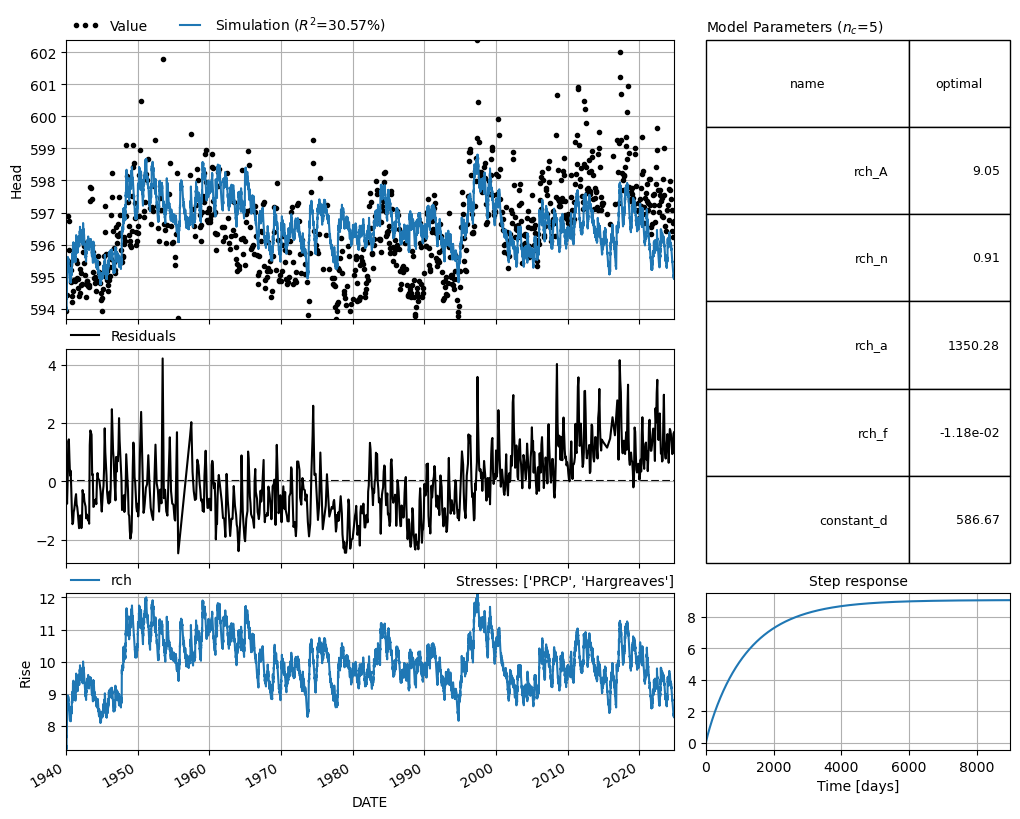

In [15]:
ml.plots.results();

#### Different recharge and response functions

In [16]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
ml.solve(tmin=1950)

INFO: Time Series 'Value': 300 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                          Fit Statistics
nfev    45                     EVP                 56.47
nobs    580                    R2                   0.56
noise   False                  RMSE                 0.96
tmin    1970-01-01 00:00:00.000001950AICc               -31.96
tmax    2024-10-31 00:00:00    BIC                -10.25
freq    D                      Obj                269.71
warmup  3650 days 00:00:00     ___                      
solver  LeastSquares           Interp.                No

Parameters (5 optimized)
                optimal     initial  vary
rch_A         26.805159    0.268052  True
rch_n          0.829335    1.000000  True
rch_a       6742.240942   10.000000  True
rch_f         -0.207844   -1.000000  True
constant_d   591.804184  596.452808  True

Warnings! (2)
Parameter 'rch_A' on upper bound: 2.68e+01
Response tmax for 'rch' > than calibration period.


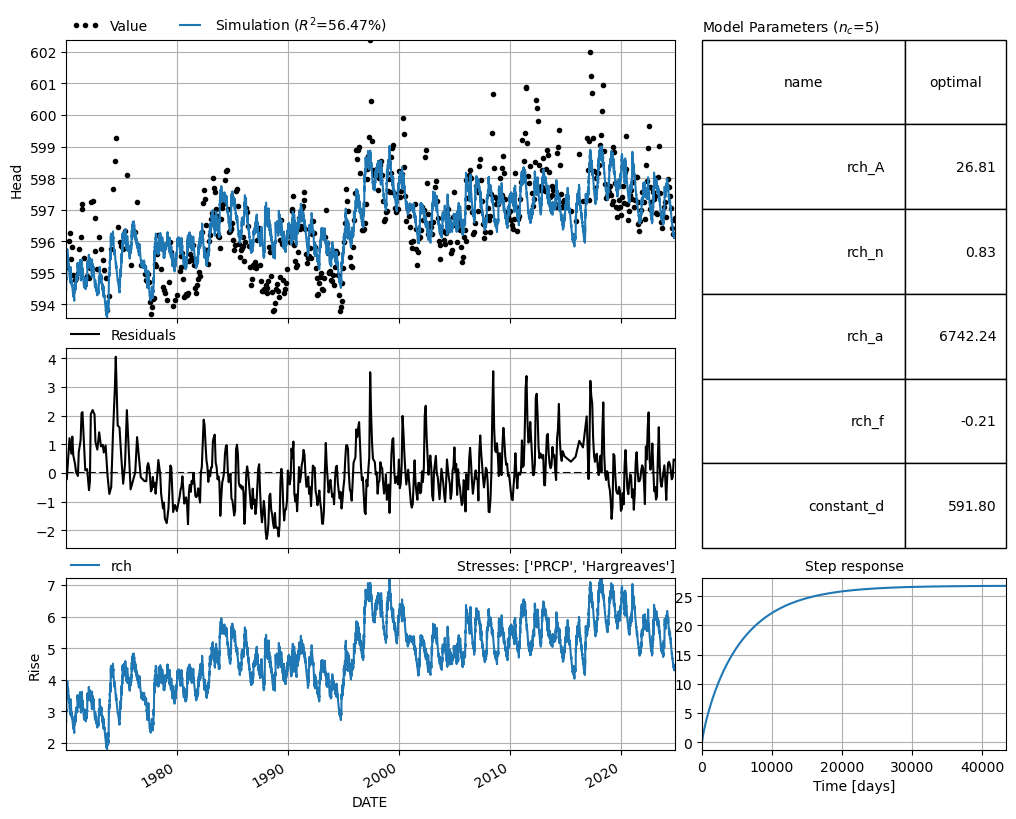

In [17]:
ml.plots.results();

In [18]:
ml1 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Berendrecht())
ml1.add_stressmodel(sm)
ml1.solve(tmin=1950)

INFO: Time Series 'Value': 300 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                          Fit Statistics
nfev    700                    EVP                 33.19
nobs    580                    R2                   0.33
noise   False                  RMSE                 1.19
tmin    1970-01-01 00:00:00.000001950AICc               220.67
tmax    2024-10-31 00:00:00    BIC                251.01
freq    D                      Obj                414.00
warmup  3650 days 00:00:00     ___                      
solver  LeastSquares           Interp.                No

Parameters (7 optimized)
                optimal     initial   vary
rch_A       1224.442417  112.637581   True
rch_n          1.404923    1.000000   True
rch_a       5311.498573   10.000000   True
rch_fi         0.900000    0.900000  False
rch_fc         1.000000    1.000000  False
rch_sr         0.250000    0.250000  False
rch_de        83.597717  250.000000   True
rch_l         50.000000    2.000000   True
rch_m          0.500000    0.500000  False
rch_ks        77.827563  

In [19]:
ml2 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml2.add_stressmodel(sm)
ml2.solve(tmin=1950)

INFO: Time Series 'Value': 300 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                           Fit Statistics
nfev    94                     EVP                  62.56
nobs    580                    R2                    0.63
noise   False                  RMSE                  0.89
tmin    1970-01-01 00:00:00.000001950AICc               -111.08
tmax    2024-10-31 00:00:00    BIC                 -72.13
freq    D                      Obj                 232.01
warmup  3650 days 00:00:00     ___                       
solver  LeastSquares           Interp.                 No

Parameters (9 optimized)
                 optimal     initial  vary
rch_A          60.719711    2.142416  True
rch_n           0.535426    1.000000  True
rch_a       10000.000000   10.000000  True
rch_scap        3.000000    1.500000  True
rch_alpha       0.000006    1.000000  True
rch_ksat        1.013689    1.000000  True
rch_beta        0.248529    0.500000  True
rch_gamma       0.604241    1.000000  True
constant_d    587.875393  596.452808  True

Warnings! (3)
P

In [20]:
ml3 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel())
ml3.add_stressmodel(sm)
ml3.solve(tmin=1950)

INFO: Time Series 'Value': 300 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Water balance error: -0.13 % of the total pe flux. Parameters: [ 41.91   0.25 123.88   0.93   1.     2.  ]
INFO: Water balance error: -0.13 % of the total pe flux. Parameters: [ 41.91   0.25 123.88   0.93   1.     2.  ]
INFO: Water balance error: -0.13 % of the total pe flux. Parameters: [ 41.91   0.25 123.88   0.93

Fit report Value                          Fit Statistics
nfev    32                     EVP                 42.03
nobs    580                    R2                   0.42
noise   False                  RMSE                 1.11
tmin    1970-01-01 00:00:00.000001950AICc               138.26
tmax    2024-10-31 00:00:00    BIC                168.61
freq    D                      Obj                359.17
warmup  3650 days 00:00:00     ___                      
solver  LeastSquares           Interp.                No

Parameters (7 optimized)
                optimal     initial   vary
rch_A         13.148473    1.882027   True
rch_n          0.606326    1.000000   True
rch_a       9999.769288   10.000000   True
rch_srmax    999.916623  250.000000   True
rch_lp         0.250000    0.250000  False
rch_ks       732.106199  100.000000   True
rch_gamma      0.353824    2.000000   True
rch_kv         1.000000    1.000000  False
rch_simax      2.000000    2.000000  False
constant_d   588.722840  

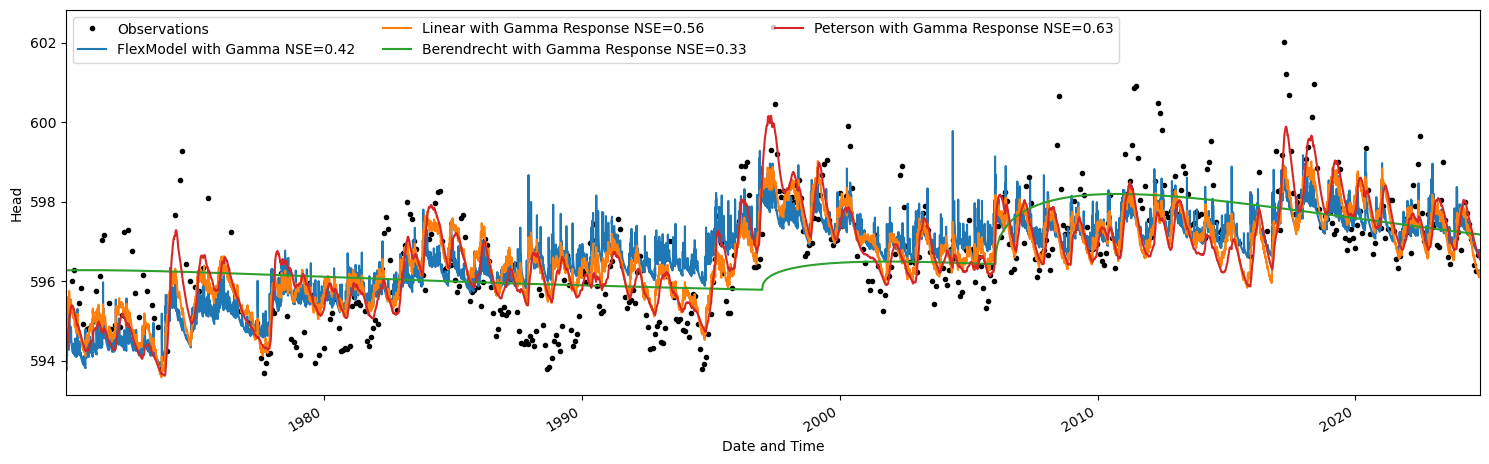

In [21]:
ax = ml3.plot(figsize=(15, 5))
ml.simulate().plot(ax=ax)
ml1.simulate().plot(ax=ax)
ml2.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "FlexModel with Gamma NSE={:.2f}".format(ml3.stats.nse()),
        "Linear with Gamma Response NSE={:.2f}".format(ml.stats.nse()),
        "Berendrecht with Gamma Response NSE={:.2f}".format(ml1.stats.nse()),
        "Peterson with Gamma Response NSE={:.2f}".format(ml2.stats.nse()),
    ],
    ncol=3,
)

### Try with the 'gw_uptake = True' Feature

In [22]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 300 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'Hargreaves' was extended in the past to 1911-12-03 00:00:00 with the mean value (4.3) of the time series.


Fit report Value                Fit Statistics
nfev    52                     EVP       30.52
nobs    936                    R2         0.31
noise   False                  RMSE       1.23
tmin    1921-11-30 00:00:00    AICc     397.46
tmax    2024-10-31 00:00:00    BIC      436.04
freq    D                      Obj      703.34
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (8 optimized)
                optimal     initial   vary
rch_A          5.261603    0.415211   True
rch_n          1.397870    1.000000   True
rch_a        300.808378   10.000000   True
rch_srmax    875.196907  250.000000   True
rch_lp         0.250000    0.250000  False
rch_ks      1222.544091  100.000000   True
rch_gamma      0.629922    2.000000   True
rch_kv         1.000000    1.000000  False
rch_simax      2.000000    2.000000  False
rch_gf         0.175502    1.000000   True
constant_d   596.416368  596.452808   True


In [23]:
ml1 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel())
ml1.add_stressmodel(sm)
ml1.solve()

INFO: Time Series 'Value': 300 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 10 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'Hargreaves' was extended in the past to 1911-12-03 00:00:00 with the mean value (4.3) of the time series.


Fit report Value                Fit Statistics
nfev    153                    EVP       33.72
nobs    936                    R2         0.34
noise   False                  RMSE       1.20
tmin    1921-11-30 00:00:00    AICc     351.23
tmax    2024-10-31 00:00:00    BIC      385.00
freq    D                      Obj      670.90
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (7 optimized)
                optimal     initial   vary
rch_A          9.157543    1.882027   True
rch_n          1.234070    1.000000   True
rch_a        368.829035   10.000000   True
rch_srmax    565.092339  250.000000   True
rch_lp         0.250000    0.250000  False
rch_ks      4701.797944  100.000000   True
rch_gamma      3.102697    2.000000   True
rch_kv         1.000000    1.000000  False
rch_simax      2.000000    2.000000  False
constant_d   593.973858  596.452808   True


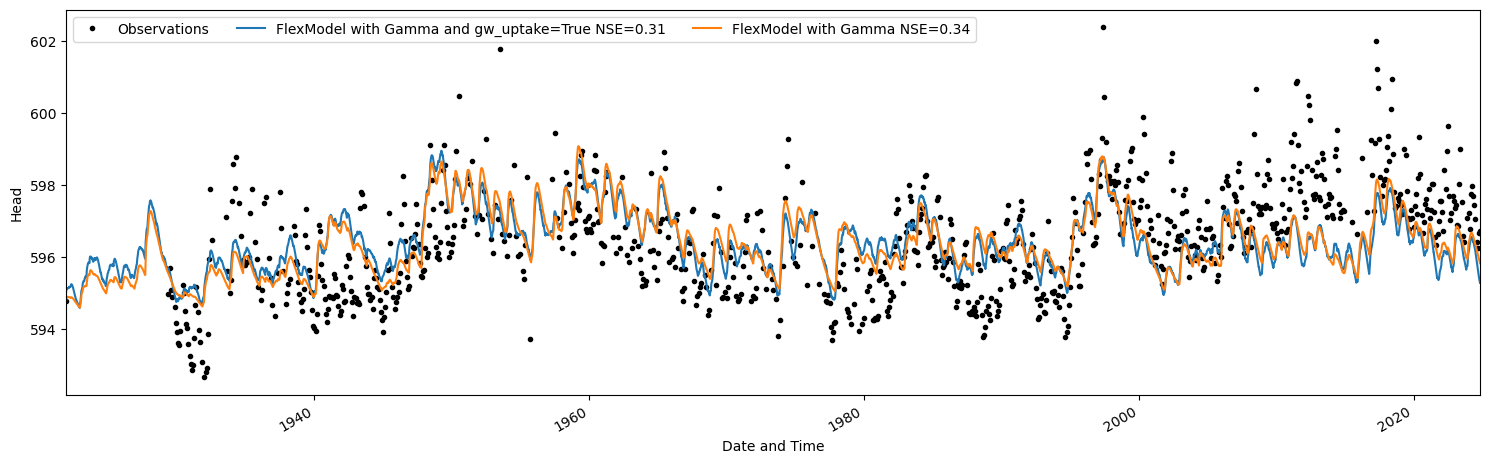

In [25]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "FlexModel with Gamma and gw_uptake=True NSE={:.2f}".format(ml.stats.nse()),
        "FlexModel with Gamma NSE={:.2f}".format(ml1.stats.nse()),
    ],
    ncol=3,
)